In [49]:
import pandas as pd
import numpy as np
import re, pickle
from gensim.parsing.preprocessing import preprocess_string, strip_numeric
from gensim.parsing.preprocessing import strip_tags, strip_punctuation
from gensim.parsing.preprocessing import strip_multiple_whitespaces,  remove_stopwords
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from keras.models import load_model
import matplotlib.style as style

In [50]:
# Import model tweets
## Tweet for model building as already been preprocessed, hence no need for text cleanup
tweets_df = pd.read_csv("data/dataset.csv", encoding="UTF-8")
tweets_df = tweets_df.dropna()
tweets_df = tweets_df.rename(columns={"selected_text":"text", "sentiment":"label"})

In [51]:
# Generate word cloud
def word_cloud(df, filename):
    ## Import word cloud mask
    corona_mask = np.array(Image.open("img/corona_3d.png"))

    ## Generate word cloud
    text = " ".join(twt for twt in df)
    wordcloud = WordCloud(max_font_size=50,  
            background_color="white",
            mode="RGBA",
            max_words=1000, 
            mask=corona_mask).generate(text)

    ## Create coloring from mask
    plt.figure(figsize=(15,30))
    image_colors = ImageColorGenerator(corona_mask)
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.show()
    wordcloud.to_file("./img/{}.png".format(filename))

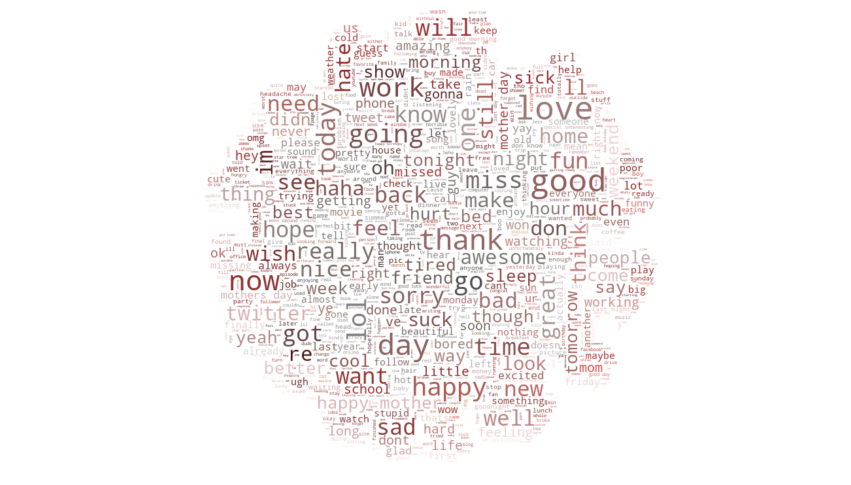

In [52]:
word_cloud(tweets_df["text"], "model_wordcloud")

In [54]:
# Import COVID-19 and vaccine tweets
tweets_covid_df = pd.read_csv("data/tweets_covid_19.csv", encoding="UTF-8")


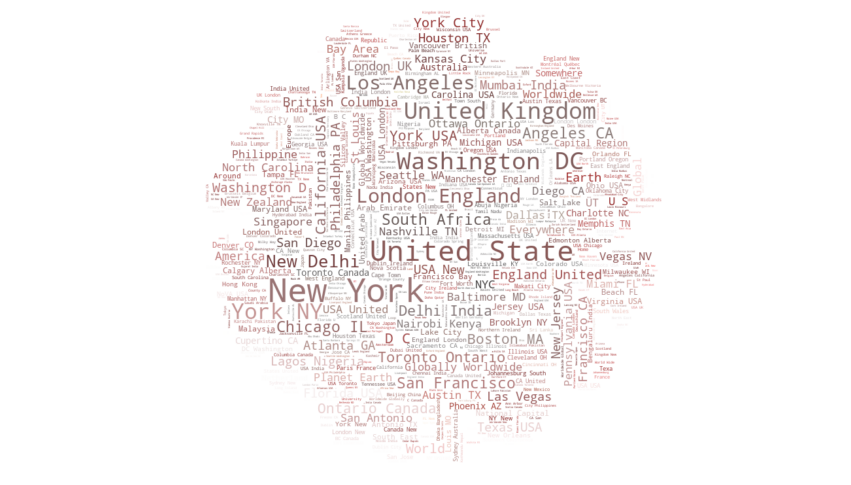

In [45]:
location = tweets_covid_df[["location"]].dropna()
word_cloud(location["location"], "location")

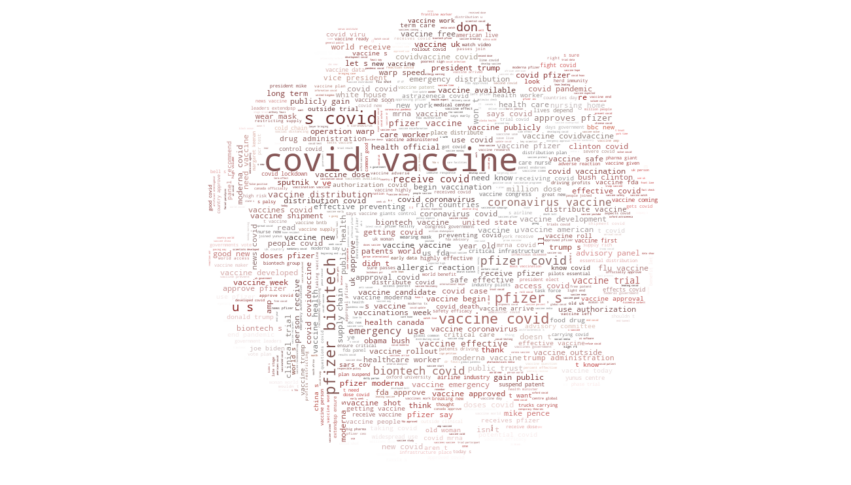

In [56]:
# Clean up tweets
CUSTOM_FILTERS = [lambda x: x.lower(),
                  lambda x: re.compile(r"https?://\S+|www\.\S+").sub(r"", x),
                  remove_stopwords,
                  strip_tags,
                  strip_punctuation,
                  strip_multiple_whitespaces,
                  strip_numeric]

tweets_covid = tweets_covid_df[["tweet"]]#.dropna()
tweets_covid["clean_tweet"] = [" ".join(preprocess_string(twt, CUSTOM_FILTERS))
                              for twt in tweets_covid["tweet"]]

word_cloud(tweets_covid["clean_tweet"], "covid_tweets_wordcloud")

In [ ]:
# Load the best model obtained during training
model = load_model("./model/model.hdf5")

# loading tokenizer
with open("./model/tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)

# Predict sentiments
sentiments = []

for twt in tweets_covid_df["clean_tweet"]:
    try:
        sequence = tokenizer.texts_to_sequences(twt)
        test = pad_sequences(sequence, maxlen=200)
        s = sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]
        sentiments.append(s)
    except:
        sentiments.append(np.nan)
        
    counter = counter + 1
    print(counter)
    
tweets_covid_df["sentiment"] = sentiments
tweets_covid_df.to_csv("./data/covid_tweets_with_sentiment.csv", header=True, index=False)

In [57]:
# Analyse Sentiments
tweet_with_sentiment = pd.read_csv("./data/covid_tweets_with_sentiment.csv").drop_duplicates()
print(len(tweet_with_sentiment))
sentiment_counts = tweet_with_sentiment["sentiment"].value_counts()

1049694


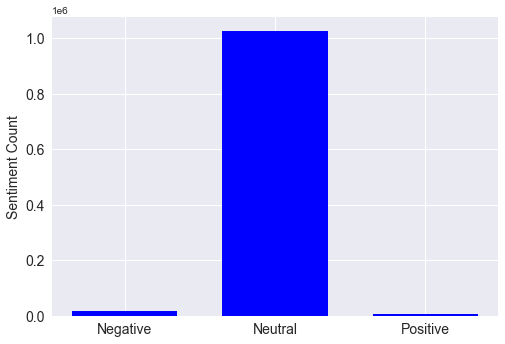

<Figure size 576x396 with 0 Axes>

In [58]:
style.use("seaborn")

x = (0, 1, 2)
sc = [sentiment_counts.Negative, sentiment_counts.Neutral, sentiment_counts.Positive]

plt.bar(x, sc, color="b", width=0.7)
plt.xticks(x, ("Negative", "Neutral", "Positive"), fontsize=14)
plt.ylabel("Sentiment Count", fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plt.savefig("./img/sentiment_count.png")